# Evaluation Toolkit

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns
import os


from metrics.f1_score_f1_pa import *
from metrics.fc_score import *
from metrics.precision_at_k import *
from metrics.customizable_f1_score import *
from metrics.AUC import *
from metrics.Matthews_correlation_coefficient import *
from metrics.affiliation.generics import convert_vector_to_events
from metrics.affiliation.metrics import pr_from_events
from metrics.vus.models.feature import Window
from metrics.vus.metrics import get_range_vus_roc

from tqdm.notebook import tqdm

from pate.PATE_metric import PATE

from sklearn import metrics
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, roc_curve, precision_recall_curve

In [6]:
def combine_all_evaluation_scores(y_test, pred_labels, anomaly_scores):
    events_pred = convert_vector_to_events(pred_labels) # [(4, 5), (8, 9)]
    events_gt = convert_vector_to_events(y_test)     # [(3, 4), (7, 10)]
    Trange = (0, len(y_test))
    affiliation = pr_from_events(events_pred, events_gt, Trange)
    true_events = get_events(y_test)
    # _, _, _, f1_score_ori, f05_score_ori = get_accuracy_precision_recall_fscore(y_test, pred_labels)
    # f1_score_pa = get_point_adjust_scores(y_test, pred_labels, true_events)[5]
    # pa_accuracy, pa_precision, pa_recall, pa_f_score = get_adjust_F1PA(y_test, pred_labels)
    # range_f_score = customizable_f1_score(y_test, pred_labels)
    # _, _, f1_score_c = get_composite_fscore_raw(y_test, pred_labels,  true_events, return_prec_rec=True)
    # precision_k = precision_at_k(y_test, anomaly_scores, pred_labels)
    # point_auc = point_wise_AUC(pred_labels, y_test)
    # range_auc = Range_AUC(pred_labels, y_test)
    # MCC_score = MCC(y_test, pred_labels)
    # results = get_range_vus_roc(y_test, pred_labels, 200) # slidingWindow = 100 default

    
    score_list = {
                #   "f1_score_ori": f1_score_ori, 
                #   "f05_score_ori" : f05_score_ori, 
                #   "f1_score_pa": f1_score_pa,
                #   "pa_accuracy":pa_accuracy, 
                #   "pa_precision":pa_precision, 
                #   "pa_recall":pa_recall, 
                #   "pa_f_score":pa_f_score,
                #   "range_f_score": range_f_score,
                  # "f1_score_c": f1_score_c, 
                #   "precision_k": precision_k,
                #   "point_auc": point_auc,
                #   "range_auc": range_auc, 
                #   "MCC_score":MCC_score, 
                  "Affiliation precision": affiliation['precision'], 
                  "Affiliation recall": affiliation['recall'],
                  # "R_AUC_ROC": results["R_AUC_ROC"], 
                  # "R_AUC_PR": results["R_AUC_PR"],
                  # "VUS_ROC": results["VUS_ROC"], 
                  # "VUS_PR": results["VUS_PR"]
                  }
    
    return score_list

In [7]:
def adjust_predicts(label, predict=None, calc_latency=False):
    
    label = np.asarray(label)
    latency = 0
    
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    for i in range(len(actual)):
        if actual[i] and predict[i] and not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                for j in range(i, 0, -1):
                    if not actual[j]:
                        break
                    else:
                        if not predict[j]:
                            predict[j] = True
                            latency += 1
        elif not actual[i]:
            anomaly_state = False
        if anomaly_state:
            predict[i] = True
        
    MCM = metrics.multilabel_confusion_matrix(actual, predict, labels = [1, 0])

    pa_tn = MCM[0][0, 0]
    pa_tp = MCM[0][1, 1]
    pa_fp = MCM[0][0, 1]
    pa_fn = MCM[0][1, 0]
        
    # pa_tn, pa_fp, pa_fn, pa_tp = confusion_matrix(actual, predict).ravel()
    prec = pa_tp / (pa_tp + pa_fp)
    rec = pa_tp / (pa_tp + pa_fn)
    if (prec+rec) == 0:
        f1_score = 0
    else:
        f1_score = 2 * (prec * rec) / (prec + rec)
    
    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4), pa_tp, pa_tn, pa_fp, pa_fn, prec , rec, f1_score
    else:
        return predict, prec, rec, f1_score, pa_tp, pa_tn, pa_fp, pa_fn

In [4]:
def add_summary_statistics(res_df):
    # Compute the sum of 'best_tp', 'best_tn', 'best_fp', 'best_fn'
    sum_best_tp = res_df['best_tp'].sum()
    sum_best_tn = res_df['best_tn'].sum()
    sum_best_fp = res_df['best_fp'].sum()
    sum_best_fn = res_df['best_fn'].sum()

    # Calculate precision, recall and f1 score
    precision = sum_best_tp / (sum_best_tp + sum_best_fp) if (sum_best_tp + sum_best_fp) > 0 else 0
    recall = sum_best_tp / (sum_best_tp + sum_best_fn) if (sum_best_tp + sum_best_fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Calculate the average and std of 'roc' and 'pr'
    roc_avg = res_df['roc'].mean()
    roc_std = res_df['roc'].std()
    pr_avg = res_df['pr'].mean()
    pr_std = res_df['pr'].std()


    sum_pa_tp = res_df['pa_tp'].sum()
    sum_pa_tn = res_df['pa_tn'].sum()
    sum_pa_fp = res_df['pa_fp'].sum()
    sum_pa_fn = res_df['pa_fn'].sum()

    # Calculate precision, recall and f1 score
    pa_precision = sum_pa_tp / (sum_pa_tp + sum_pa_fp) if (sum_pa_tp + sum_pa_fp) > 0 else 0
    pa_recall = sum_pa_tp / (sum_pa_tp + sum_pa_fn) if (sum_pa_tp + sum_pa_fn) > 0 else 0
    pa_f1_score = 2 * (pa_precision * pa_recall) / (pa_precision + pa_recall) if (pa_precision + pa_recall) > 0 else 0



    aff_f1_mean = res_df['aff_f1'].mean()
    aff_f1_std = res_df['aff_f1'].std()

    R_AUC_ROC_mean = res_df['R_AUC_ROC'].mean()
    R_AUC_ROC_std = res_df['R_AUC_ROC'].std()

    R_AUC_PR_mean = res_df['R_AUC_PR'].mean()
    R_AUC_PR_std = res_df['R_AUC_PR'].std()

    VUS_ROC_mean = res_df['VUS_ROC'].mean()
    VUS_ROC_std = res_df['VUS_ROC'].std()

    VUS_PR_mean = res_df['VUS_PR'].mean()
    VUS_PR_std = res_df['VUS_PR'].std()

    PATE_mean = res_df['PATE'].mean()
    PATE_std = res_df['PATE'].std()

    PATE_F1_mean = res_df['PATE_F1'].mean()
    PATE_F1_std = res_df['PATE_F1'].std()

    summary_row = pd.Series({
        'best_pre': precision,
        'best_rec': recall,
        'b_f_1': f1_score,
        'roc': roc_avg,
        'roc_std': roc_std,
        'pr': pr_avg,
        'pr_std': pr_std,
        # 'pa_pre': pa_precision,
        # 'pa_rec': pa_recall,
        # 'pa_f1': pa_f1_score,
        'aff_f1_mean': aff_f1_mean,
        'aff_f1_std': aff_f1_std,
        # 'R_AUC_ROC_mean': R_AUC_ROC_mean,
        # 'R_AUC_ROC_std': R_AUC_ROC_std,
        # 'R_AUC_PR_mean': R_AUC_PR_mean,
        # 'R_AUC_PR_std': R_AUC_PR_std,
        # 'VUS_ROC_mean': VUS_ROC_mean,
        # 'VUS_ROC_std': VUS_ROC_std,
        # 'VUS_PR_mean': VUS_PR_mean,
        # 'VUS_PR_std': VUS_PR_std,
        'PATE_mean': PATE_mean,
        'PATE_std': PATE_std,
        'PATE_F1_mean': PATE_F1_mean,
        'PATE_F1_std': PATE_F1_std

    })
    # Append the results to the dataframe
    # summary_row = pd.Series({
    #     'best_tp': sum_best_tp,
    #     'best_tn': sum_best_tn,
    #     'best_fp': sum_best_fp,
    #     'best_fn': sum_best_fn,
    #     'best_pre': precision,
    #     'best_rec': recall,
    #     'b_f_1': f1_score,
    #     'roc': roc_avg,
    #     'roc_std': roc_std,
    #     'pr': pr_avg,
    #     'pr_std': pr_std,
    #     'pa_tp': sum_pa_tp,
    #     'pa_tn': sum_pa_tn,
    #     'pa_fp': sum_pa_fp,
    #     'pa_fn': sum_pa_fn,
    #     'pa_pre': pa_precision,
    #     'pa_rec': pa_recall,
    #     'pa_f1': pa_f1_score,
    #     'aff_f1_mean': aff_f1_mean,
    #     'aff_f1_std': aff_f1_std,
    #     'R_AUC_ROC_mean': R_AUC_ROC_mean,
    #     'R_AUC_ROC_std': R_AUC_ROC_std,
    #     'R_AUC_PR_mean': R_AUC_PR_mean,
    #     'R_AUC_PR_std': R_AUC_PR_std,
    #     'VUS_ROC_mean': VUS_ROC_mean,
    #     'VUS_ROC_std': VUS_ROC_std,
    #     'VUS_PR_mean': VUS_PR_mean,
    #     'VUS_PR_std': VUS_PR_std

    # })

    
    return summary_row

In [8]:
res_df = pd.DataFrame(columns=['name', 'roc', 'pr', 'best_tp', 'best_tn', 'best_fp', 'best_fn', 'best_pre', 'best_rec', 
                                'b_f_1', 'pa_tp', 'pa_tn', 'pa_fp', 'pa_fn', 'pa_pre', 'pa_rec', 'pa_f1', 'latency', 'aff_pre', 'aff_rec', 'aff_f1', 'R_AUC_ROC', 'R_AUC_PR', 'VUS_ROC', 'VUS_PR', 'PATE', 'PATE_F1']) 


ds_name = 'sre'  #'MSL'
path = os.path.join('results/', ds_name)
file_list = os.listdir(path)
file_list = sorted(file_list)


for filename in file_list: #data_info['chan_id']: #files: #data_info['chan_id']: #['uni-ts-all.csv']:
    if filename!='GECCO' and filename!='.json': #'Power' in filename : # and ('real_' in filename) : #'train' in filename:
        print(filename, ds_name,
              f"results/{ds_name}/{filename}/classification/classification_trainprobs.csv"
              )
        df_train = pd.read_csv(f"results/{ds_name}/{filename}/classification/classification_trainprobs.csv")
        df_test = pd.read_csv(f"results/{ds_name}/{filename}/classification/classification_testprobs.csv")
        cl_num = df_train.shape[1] - 1

        df_train['Class'] = np.where((df_train['Class'] == 0), 0, 1)
        df_train['pred']=df_train[df_train.columns[0:cl_num]].idxmax(axis=1)

        score_col = df_train['pred'].value_counts().idxmax()
        
        df_test['Class'] = np.where((df_test['Class'] == 0), 0, 1)
        df_test['pred'] = df_test[df_test.columns[0:cl_num]].idxmax(axis=1)
#         print(df_test['pred'].value_counts())
        
#         score_col = df_test['pred'].value_counts().idxmax()
        #print('score col: ', score_col)
        
        roc_auc, pr_auc, best_tn, best_tp, best_fp, best_fn, best_pre, best_rec, best_f1 = 0, 0, 0, 0, 0, 0, 0, 0, 0
        try:

            df_test['pred'] = np.where((df_test['pred'] == score_col), 0, 1)

            MCM = metrics.multilabel_confusion_matrix(df_test['Class'], df_test['pred'], labels = [1, 0])

            tn = MCM[0][0, 0]
            tp = MCM[0][1, 1]
            fp = MCM[0][0, 1]
            fn = MCM[0][1, 0]

            if (tp+fp) == 0:
                pre = 0
            else:
                pre=tp/(tp+fp)
            if (tp+fn) == 0:
                recall = 0
            else:
                recall = tp/(tp+fn)
            if (pre + recall) == 0:
                f_1 = 0
            else:
                f_1 = 2*pre*recall/(pre+recall)
            # print('f-1 : ', f_1)

            scores = 1-df_test[score_col]

            roc_auc = roc_auc_score(df_test['Class'], scores)
            pr_auc = average_precision_score(df_test['Class'], scores)

            fpr, tpr, thresholds = roc_curve(df_test['Class'], scores, pos_label=1)
            precision, recall, thresholds = precision_recall_curve(df_test['Class'], scores, pos_label=1)

            res = pd.DataFrame()
            res['pre'] = precision
            res['rec'] = recall
            res['f1'] = 2*res['pre']*res['rec'] / (res['pre']+res['rec'])
            best_idx = res['f1'].argmax()
            best_f1 = res['f1'][best_idx]
            best_pre = res['pre'][best_idx]
            best_rec = res['rec'][best_idx]
            best_thr = thresholds[best_idx]
            print('Best f1 : ', best_f1, 'best_thr', best_thr)
            anomalies = [True if s >= best_thr else False for s in scores]

            best_tn, best_fp, best_fn, best_tp = confusion_matrix(df_test['Class'], anomalies).ravel()

            # print(type(df_test['Class'].values), type(np.array(anomalies)), type(scores.values))

            all_evals = combine_all_evaluation_scores(df_test['Class'].values, np.array(anomalies), scores.values)
            
            aff_pre = all_evals['Affiliation precision']
            aff_rec = all_evals['Affiliation recall']
            aff_f1 = 2 * (aff_pre * aff_rec) / (aff_pre + aff_rec) if (aff_pre + aff_rec) > 0 else 0
            # print(all_evals)

            R_AUC_ROC = 0 #all_evals['R_AUC_ROC']
            R_AUC_PR = 0 #all_evals['R_AUC_PR']
            VUS_ROC = 0 #all_evals['VUS_ROC']
            VUS_PR = 0 #all_evals['VUS_PR']


            pate = PATE(df_test['Class'].values, scores.values, binary_scores = False, n_jobs=-1)
            pate_f1 = PATE(df_test['Class'].values, np.array(anomalies), binary_scores = True, n_jobs=-1)
            print('PATE: ', pate, '\t PATE_F1: ', pate_f1)

        except ValueError:
            print('ERROR ++++++++++++++')
            pass

        
        pa_f1 = -1
        for thr in thresholds:
            preds_pa = [True if s >= thr else False for s in scores]
            pa_prediction, t_latency, t_tp, t_tn, t_fp, t_fn, t_pre, t_rec, t_f1 = adjust_predicts(df_test['Class'], preds_pa, True)
            if t_f1 > pa_f1:
                latency, pa_tp, pa_tn, pa_fp, pa_fn, pa_pre, pa_rec, pa_f1 = t_latency, t_tp, t_tn, t_fp, t_fn, t_pre, t_rec, t_f1
        
        new_row = pd.Series([filename, roc_auc, pr_auc, best_tp, best_tn, best_fp, best_fn, best_pre, best_rec, best_f1,
                                pa_tp, pa_tn, pa_fp, pa_fn, pa_pre, pa_rec, pa_f1, latency, aff_pre, aff_rec, aff_f1, R_AUC_ROC, R_AUC_PR, VUS_ROC, VUS_PR, pate, pate_f1],
                                index=['name', 'roc', 'pr', 'best_tp', 'best_tn', 'best_fp', 'best_fn', 'best_pre', 'best_rec', 
                                'b_f_1', 'pa_tp', 'pa_tn', 'pa_fp', 'pa_fn', 'pa_pre', 'pa_rec', 'pa_f1', 'latency', 'aff_pre', 'aff_rec', 'aff_f1', 'R_AUC_ROC', 'R_AUC_PR', 'VUS_ROC', 'VUS_PR', 'PATE', 'PATE_F1'])
        
        
        res_df = res_df._append(new_row, ignore_index=True) 
                
final_results = add_summary_statistics(res_df)
res_df.to_csv(f'results/{ds_name}/sre_cuda_allmetrics.csv')

single-url-method sre results/sre/single-url-method/classification/classification_trainprobs.csv
Best f1 :  0.12941079249648788 best_thr 0.6523767709732056
PATE:  0.49713271220001504 	 PATE_F1:  0.13388574941636544


/tmp/ipykernel_3281707/2564610785.py:117: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_df = res_df._append(new_row, ignore_index=True)


sre_cuda_allmetrics.csv sre results/sre/sre_cuda_allmetrics.csv/classification/classification_trainprobs.csv


NotADirectoryError: [Errno 20] Not a directory: 'results/sre/sre_cuda_allmetrics.csv/classification/classification_trainprobs.csv'

In [9]:
res_df

,name,roc,pr,best_tp,best_tn,best_fp,best_fn,best_pre,best_rec,b_f_1,...,latency,aff_pre,aff_rec,aff_f1,R_AUC_ROC,R_AUC_PR,VUS_ROC,VUS_PR,PATE,PATE_F1
0,single-url-method,0.5,0.064081,783,0,11436,0,0.064081,1.0,0.120443,...,0.0,0.501955,1.0,0.668403,0,0,0,0,0.533504,0.125592


In [9]:
add_summary_statistics(res_df)

best_pre        0.069182
best_rec        1.000000
b_f_1           0.129411
roc             0.488157
roc_std              NaN
pr              0.062829
pr_std               NaN
aff_f1_mean     0.662555
aff_f1_std           NaN
PATE_mean       0.497133
PATE_std             NaN
PATE_F1_mean    0.133886
PATE_F1_std          NaN
dtype: float64

In [9]:
from utils.evaluate_utils import get_predictions
from utils.common_config import get_model, get_aug_train_dataset, get_val_dataloader, get_train_transformations
from utils.config import create_config

p = create_config("configs/env.yml", "configs/classification/carla_classification_sre.yml", "single-url-method")
p["batch_size"] = 1
model = get_model(p, p["pretext_model"]).to("cuda:3")

train_transformations = get_train_transformations(p)
train_dataset = get_aug_train_dataset(p, train_transformations, to_neighbors_dataset = True, one_device="cuda:3")
tst_dl = get_val_dataloader(p, train_dataset)

RuntimeError: Error(s) in loading state_dict for ClusteringModel:
	size mismatch for backbone.layers.0.layers.0.layers.0.weight: copying a param with shape torch.Size([12, 5, 8]) from checkpoint, the shape in current model is torch.Size([12, 1, 8]).
	size mismatch for backbone.layers.0.residual.0.weight: copying a param with shape torch.Size([12, 5, 1]) from checkpoint, the shape in current model is torch.Size([12, 1, 1]).

In [8]:
negs = []
pos = []

for batch in tqdm(tst_dl):
    ts = batch["anchor"]
    target = batch["target"]

    if len(pos) >= 10 and target[0] == 0:
        continue

    if len(negs) >= 10 and target[0] == 1:
        continue

    if len(negs) == 10 and len(pos) == 10:
        break

    bs, w, h = ts.shape
    res = model(ts.view(bs, h, w), forward_pass='return_all')
    features = res["features"].detach().cpu().numpy().reshape(1, 24)
    if target[0] == 0:
        pos.append(features)
    else:
        negs.append(features)


    # output = res['output']
    # if return_features:
    #     features[ptr: ptr+bs] = res['features']
    #     ptr += bs
    # for i, output_i in enumerate(output):
    #     predictions[i].append(torch.argmax(output_i, dim=1))
    #     probs[i].append(F.softmax(output_i, dim=1))

    # if include_neighbors:
    #     nneighbors.append(batch['possible_nneighbors'])
    #     fneighbors.append(batch['possible_fneighbors'])

# plt.imshow(np.concatenate(negs))

NameError: name 'tst_dl' is not defined

In [7]:
np.random.seed(42)

np.random.shuffle(pos)
np.random.shuffle(negs)

NameError: name 'negs' is not defined

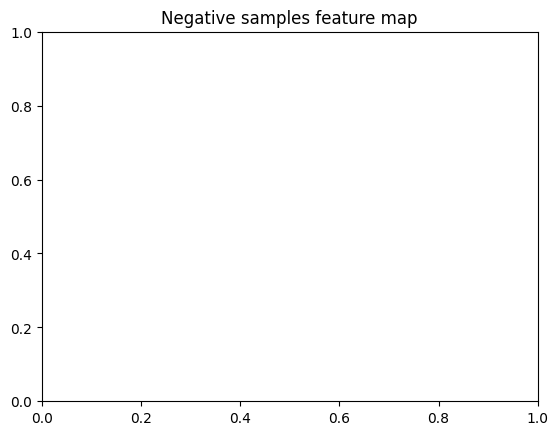

In [3]:
plt.title("Negative samples feature map")
sns.heatmap(np.concatenate(negs[:10]))
plt.xlabel("Features")
plt.ylabel("Samples")

<Axes: >

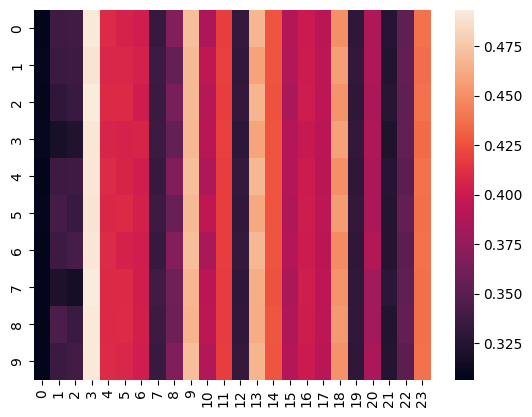

In [ ]:
sns.heatmap(np.concatenate(pos[:10]))